In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
import joblib

In [2]:
df = pd.read_csv('cleaned_vehicles.csv')

In [3]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,leather_seats
0,35990,2010,chevrolet,good,8,gas,32742.0,clean,automatic,rwd,NaN,other,NaN,0
1,7500,2014,hyundai,excellent,4,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,0
2,4900,2006,bmw,good,6,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,0
3,2000,1974,chevrolet,good,4,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,0
4,19500,2005,ford,excellent,8,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,1


In [4]:
df.shape

(400724, 14)

In [5]:
df_features = df[['year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'leather_seats']]
target = df['price']

### Creating dummies for categorical variables

In [6]:
df_features =  pd.get_dummies(df_features, columns=['condition'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['fuel'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['title_status'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['transmission'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['drive'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['size'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['type'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['paint_color'], drop_first = True )
df_features =  pd.get_dummies(df_features, columns=['manufacturer'], drop_first = True )

In [7]:
df_features.shape

(400724, 86)

### Function to calculate MAPE(Mean Absolute Percentage Error)

In [8]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state = 34, test_size = 0.25)

## Dummy Regressor

In [10]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(df_features, target)
dummy_regr.predict(df_features)

array([15206.33861211, 15206.33861211, 15206.33861211, ...,
       15206.33861211, 15206.33861211, 15206.33861211])

In [11]:
df.price.mean()

15206.338612112077

## Baseline Model

In [12]:
lm = linear_model.LinearRegression()
lm = lm.fit(X_train, y_train)

In [13]:
y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training RMSE: ' , train_rmse)
print('MAPE: ' , mape(y_train, y_train_pred))

Training RMSE:  6979.949951740229
MAPE:  105.9429541591549


In [14]:
y_pred = lm.predict(X_test)

In [15]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Test RMSE: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('MAPE: ' , mape(y_test, y_pred))

Test RMSE: 6962.3932397675
MAPE:  107.62293781343702


## Checking Multicollinearity

In [16]:
corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [17]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

[]


## LASSO

In [18]:
# training the model

lasso = Lasso(alpha = .1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('MAPE: ' , mape(y_test, y_pred))

Training Error: 6980.088690059669
Testing Error: 6962.430043040073
MAPE:  107.61756848881878


<AxesSubplot:title={'center':'Modal Coefficients'}>

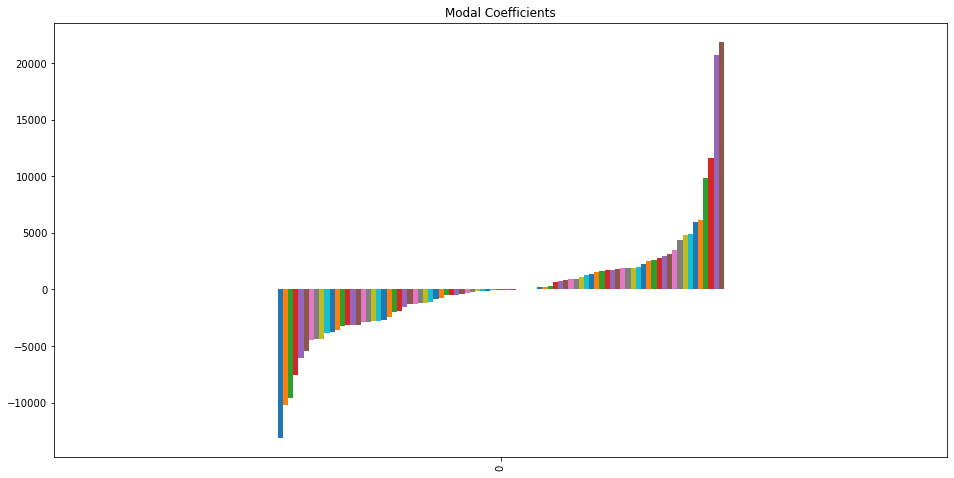

In [19]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

### Decision Tree Regressor

In [20]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

y_train_pred = dt.predict(X_train)
y_pred = dt.predict(X_test)

In [21]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('MAPE: ' , mape(y_test, y_pred))

Training Error: 1511.7692006573848
Testing Error: 4921.356733521919
MAPE:  48.0735213771954


### Grid Search Decision Tree

In [22]:
dt = DecisionTreeRegressor()

In [23]:
parameters = {'max_depth': [4, 6, 8],
              'max_features': [0.4, 0.6, 0.8]
        }

In [24]:
grid_tree = GridSearchCV(dt, parameters, cv = 5, scoring='neg_root_mean_squared_error', verbose = 1, n_jobs = -1)
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'max_features': [0.4, 0.6, 0.8]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [25]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

-6230.663905915233
{'max_depth': 8, 'max_features': 0.8}
DecisionTreeRegressor(max_depth=8, max_features=0.8)


In [26]:
y_pred_test = grid_tree.best_estimator_.predict(X_test)
y_pred_train = grid_tree.best_estimator_.predict(X_train)

print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('MAPE: ' , mape(y_test, y_pred))

Training Error: 1511.7692006573848
Testing Error: 4921.356733521919
MAPE:  48.0735213771954


### Random Forest

In [27]:
rf = RandomForestRegressor(n_estimators = 200, n_jobs = -1, verbose = 1)
rf.fit(X_train,y_train)

y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.8s finished


In [28]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('MAPE: ' , mape(y_test, y_pred))

Training Error: 1986.5306528686474
Testing Error: 3882.592807914919
MAPE:  46.925402097411926


### Grid Search Random Forest

In [29]:
rf = RandomForestRegressor()
parameters = {
    'n_estimators': [100, 500],
    'max_depth': [6, 8],
              'max_features': [0.6, 0.8]
        }

In [30]:
grid_tree = GridSearchCV(rf, parameters, cv = 5, scoring='neg_root_mean_squared_error', verbose = 1, n_jobs = -1)
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed: 18.7min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 22.4min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 8], 'max_features': [0.6, 0.8],
                         'n_estimators': [100, 500]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [31]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

-5906.803772727428
{'max_depth': 8, 'max_features': 0.6, 'n_estimators': 500}
RandomForestRegressor(max_depth=8, max_features=0.6, n_estimators=500)


In [32]:
y_pred_test = grid_tree.best_estimator_.predict(X_test)
y_pred_train = grid_tree.best_estimator_.predict(X_train)

print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('MAPE: ' , mape(y_test, y_pred))

Training Error: 1986.5306528686474
Testing Error: 3882.592807914919
MAPE:  46.925402097411926


### XGBoost

In [34]:
xgbr = XGBRegressor(learning_rate = 1, n_estimators = 700, max_depth = 8,
                       n_jobs = -1, verbosity = 1) 
xgbr.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1, max_delta_step=0, max_depth=8, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=700,
             n_jobs=-1, num_parallel_tree=1, random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [35]:
y_train_pred = xgbr.predict(X_train)
y_pred = xgbr.predict(X_test)

In [36]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('MAPE: ' , mape(y_test, y_pred))

Training Error: 2337.2530874202716
Testing Error: 4419.005516001077
MAPE:  54.12005360183009


### ExtraTrees Regressor

In [34]:
et = ExtraTreesRegressor(n_estimators = 100,
                        n_jobs = -1,
                        verbose = 1)
et.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.8s finished


ExtraTreesRegressor(n_jobs=-1, verbose=1)

In [35]:
y_train_pred = et.predict(X_train)
y_pred = et.predict(X_test)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.4s finished


In [36]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('MAPE: ' , mape(y_test, y_pred))

Training Error: 1511.774658048527
Testing Error: 3855.8728831216213
MAPE:  43.008232243776554


### Final Model

In [53]:
final_model = ExtraTreesRegressor(n_estimators = 100,
                        n_jobs = -1,
                        verbose = 1)
final_model.fit(df_features, target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


ExtraTreesRegressor(n_jobs=-1, verbose=1)

In [54]:
final_model

ExtraTreesRegressor(n_jobs=-1, verbose=1)

In [66]:
joblib.dump(final_model, 'final_model.pkl' )

['final_model.pkl']